# Wprowadzenie do problemu

Ninejsze badanie ma na celu sprawdzenie powiązania stanu uzębienia w stosunku do pkb kraju, jego wydatków na opiekę zdrowotną, spożycia cukru oraz poziomu piśmiennictwa.

### Posiadane Dane

Dysponujemy następującymi danymi:
- Złe zęby [badteeth]
    * Tabela zawierająca średnią ważoną ilości zębów z próchnicą/brakujących/wypełnionych pośród 12latków w roku 2004.
Ma ona za zadanie pokazywać częstość występowania próchnicy w danej populacji.
    * Będzie to najważniejsza tabela w naszej analizie
    * Dane z WHO
    
- Krajowe wydatki na zdrowie per capita [healthexpend]
    * Wyrażone po średnim kursie wymiany na dolara w danym roku
    * Dane z WHO
- Konsumpcja cukru [sugar_consumption]
    * w gramach na głowę na dzień
    * Dane z FAO
    
- Piśmienność dorosłych [literacy]
    * Procent ludności powyżej 15 r.ż. która potrafi ze zrozumieniem przeczytać i napisać krótkie, proste oświadczenie o ich codziennym życiu
    *Dane z UNESCO
    
- Produkt krajowy brutto per capita [gdp]
    * niezmienna siła nabywcza w wysokości 2000US$
    * Dane z World Bank
    
    

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
 
# wczytanie danych
literacy = pd.read_csv('Teeth/adultliteracy.csv')
badteeth = pd.read_csv('Teeth/badteeth.csv')
gdp = pd.read_csv('Teeth/gdp.csv')
healthexpend = pd.read_csv('Teeth/healthexpend.csv')
sugar_consumption = pd.read_csv('Teeth/sugar_consumption.csv')

# Przygotowanie danych
<ol>
<li>Usuwamy puste wiersze i kolumny we wczytanych tabelach oraz zmieniamy nazwę kolumny z państwami,</li>
<li>We wszystkich tabelach poza badteeth wyliczamy średnią dla danego państwa na przestrzeni lat,</li>
<li>We wszystkich tabelach poza badteeth wyliczamy współczynnik zmiany w ciągu roku,</li>
<li>Korzystając z faktu, że atrybut badteeth jest ilościowy, można posortować wiersze malejąco, aby zwiększyć czytelność,</li>
<li>Scalenie danych w jedną tabelę zawierającą wszystkie atrybuty</li>
</ol>


In [27]:
# 1 usuniecie wierszy i kolumn zawierajacych same NaN
badteeth.dropna(axis=['index', 'columns'], how='all', inplace=True)
literacy.dropna(how="all", subset=list(literacy.columns)[1:], inplace=True)
gdp.dropna(how="all", subset=list(gdp.columns)[1:], inplace=True)
healthexpend.dropna(how="all", subset=list(healthexpend.columns)[1:], inplace=True)
sugar_consumption.dropna(how="all", subset=list(sugar_consumption.columns)[1:], inplace=True)

#zmiana nazw kolumn
badteeth.rename(columns={badteeth.columns[0]:"Country","X2004":"badteeth"}, inplace=True)
literacy.rename(index=str, columns={literacy.columns[0]:"Country"}, inplace=True)
gdp.rename(index=str, columns={gdp.columns[0]:"Country"}, inplace=True)
healthexpend.rename(columns={healthexpend.columns[0]:"Country"}, inplace=True)
sugar_consumption.rename(columns = {sugar_consumption.columns[0]:"Country"}, inplace=True)

# 2 wyliczenie średniej z wartości na przestrzeni lat we wszystkich tabelach poza badteeth
# wyliczenie współczynnika zmiany atrybutu*
#Postanowiliśmy policzyć dla naszych tabel w jakim stadium znajduje się dany kraj przyglądając
#się okresom n-letnim wyliczymy wspólczynnik odpowiadający za prędkość wzrostu/spadku danego atrybutu przez odpowiedni okres

def change_rate(table,names, ignored_lasts):
    name = names +'_change_rate'
    table[name] = np.nan
    for index, row in table[table.columns[1:ignored_lasts]].iterrows():
        idx1 = row.first_valid_index()
        idx2 = row.last_valid_index()
        if idx1:
            table.loc[index, name] = (row[idx2]-row[idx1])/(int(idx2[1:])-int(idx1[1:])+1)
    table[names+'_mean']=table[list(table.columns)[1:-1]].mean(axis=1)
    # literacy.drop(list(literacy.columns)[1:-2], axis=1, inplace=True)
    table.drop(list(table.columns)[1:-2], axis=1, inplace=True)
    return table

literacy =  change_rate(literacy, 'literacy',-8)
# literacy

gdp = change_rate(gdp, 'gdp',-8)
# gdp

healthexpend =  change_rate(healthexpend, 'health_expend',-7)
# healthexpend
sugar_consumption = change_rate(sugar_consumption,'sugar_consumption',-1)
# sugar_consumption


# 3 posortowanie tabeli badteeth po liczbie zepsutych zębów malejąco sprawi, że ostateczna tabela będzie bardziej czytelna
badteeth.sort_values(by=["badteeth"], ascending=[0], inplace = True)

# 4 scalenie wszystkich tabel do tabeli badteeth
merged_data = badteeth.merge(literacy,on='Country', how = "inner").merge(gdp,on='Country', how="inner").merge(sugar_consumption,on='Country', how="inner").merge(healthexpend,on='Country', how="inner")
merged_data = merged_data.dropna()
merged_data.head()

,Country,badteeth,literacy_change_rate,literacy_mean,gdp_change_rate,gdp_mean,sugar_consumption_change_rate,sugar_consumption_mean,health_expend_change_rate,health_expend_mean
0,Saudi Arabia,5.9,0.925853,80.046624,62.171299,10460.159368,1.307500,63.511591,16.681698,282.826662
1,Guatemala,5.2,0.543343,69.723543,17.533181,1487.355625,1.120909,97.758182,2.275849,44.111681
2,Mauritius,4.9,0.403130,84.339633,90.979638,3074.829677,0.062273,120.550000,5.009366,100.265111
3,Brunei,4.8,0.706520,88.439129,-162.377489,20991.519647,0.311364,108.220000,18.283065,549.706067
4,Bosnia and Herzegovina,4.8,0.000000,97.332859,125.311945,1590.190034,2.317692,45.101538,10.889351,132.698130


# Wstępna analiza danych
<ol>
    <li>Liczba analizowanych państw,</li>
    <li>Poziom wypełnienia danych,</li>
    <li>Zakres zmienności atrybutów,</li>
    <li>Ogólny opis danych i wizualizacja zależność liczby zepsutych zębów od wszystkich pozostałych atrybutów</li>
</ol>


In [28]:
merged_data.shape

(119, 10)

In [29]:
# poziom wypełnienia przygotowanych danych
#czy wszystkie dane są pełne
not merged_data.isnull().any().any()

True

In [30]:
# zakres zmienności atrybutów ilościowych
merged_data.iloc[:,1:].apply(lambda x: x.max() - x.min())

badteeth                             5.600000
literacy_change_rate                 1.724317
literacy_mean                       81.562110
gdp_change_rate                   1036.077632
gdp_mean                         38086.339829
sugar_consumption_change_rate       11.379231
sugar_consumption_mean             153.860909
health_expend_change_rate          117.276127
health_expend_mean                1703.087236
dtype: float64

In [31]:
merged_data.describe()

,badteeth,literacy_change_rate,literacy_mean,gdp_change_rate,gdp_mean,sugar_consumption_change_rate,sugar_consumption_mean,health_expend_change_rate,health_expend_mean
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,2.073529,0.470063,78.012251,38.130249,3042.500719,0.623851,68.731877,6.574884,171.716859
std,1.219153,0.470106,20.925799,103.844223,5029.237325,1.136912,39.178135,14.752136,281.784888
min,0.300000,-0.051814,18.201399,-690.720709,139.937213,-2.528462,2.677727,-23.792774,2.155842
25%,1.165000,0.005132,66.268106,1.926497,429.293100,0.124545,36.585114,0.369898,15.789040
50%,1.900000,0.318580,83.559337,14.366240,1277.797569,0.498182,67.995227,1.331230,66.530291
75%,2.800000,0.908684,96.444063,53.530381,3225.388612,0.934091,98.505455,5.752688,181.257959
max,5.900000,1.672503,99.763509,345.356923,38226.277042,8.850769,156.538636,93.483353,1705.243078


Propozycje problemów do rozważenia:
- jaki zepsute zęby różnią się w zależności od wydatków rzadowych/pkb/alfabetyzmu
- narzucenie krajom klas bogactwa analiza z uwzględnieniem klas
* Jak zmienia się spożycie cukru w zalezności od pkb
* jaki wpływ maja współczynniki zmiany parametrów na dziury 
    

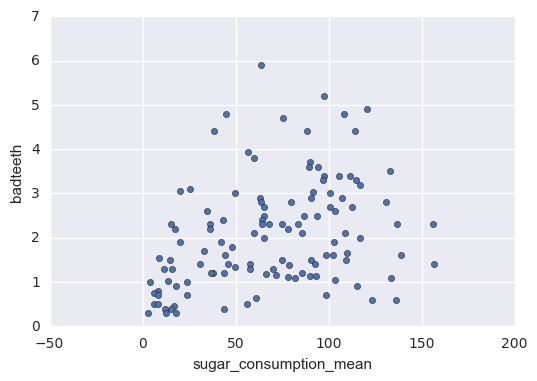

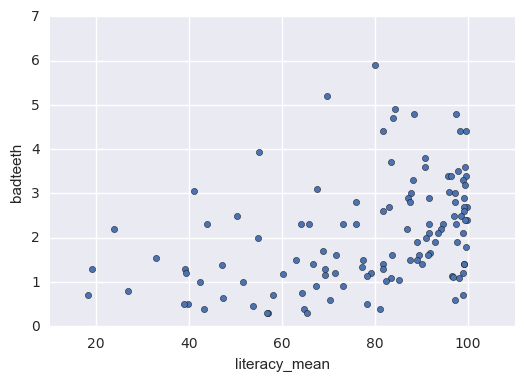

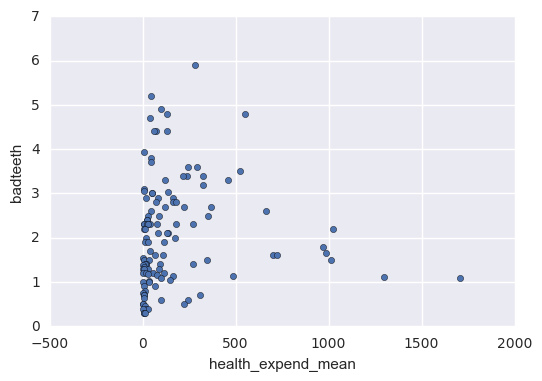

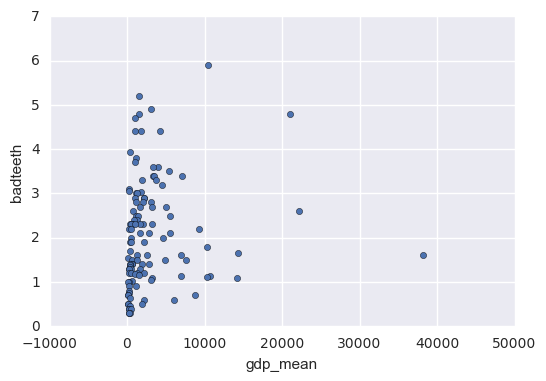

In [32]:
merged_data.plot.scatter(x='sugar_consumption_mean',y='badteeth')
merged_data.plot.scatter(x='literacy_mean',y='badteeth')
merged_data.plot.scatter(x='health_expend_mean',y='badteeth')
merged_data.plot.scatter(x='gdp_mean',y='badteeth')

# Macierz wykresów punktowych

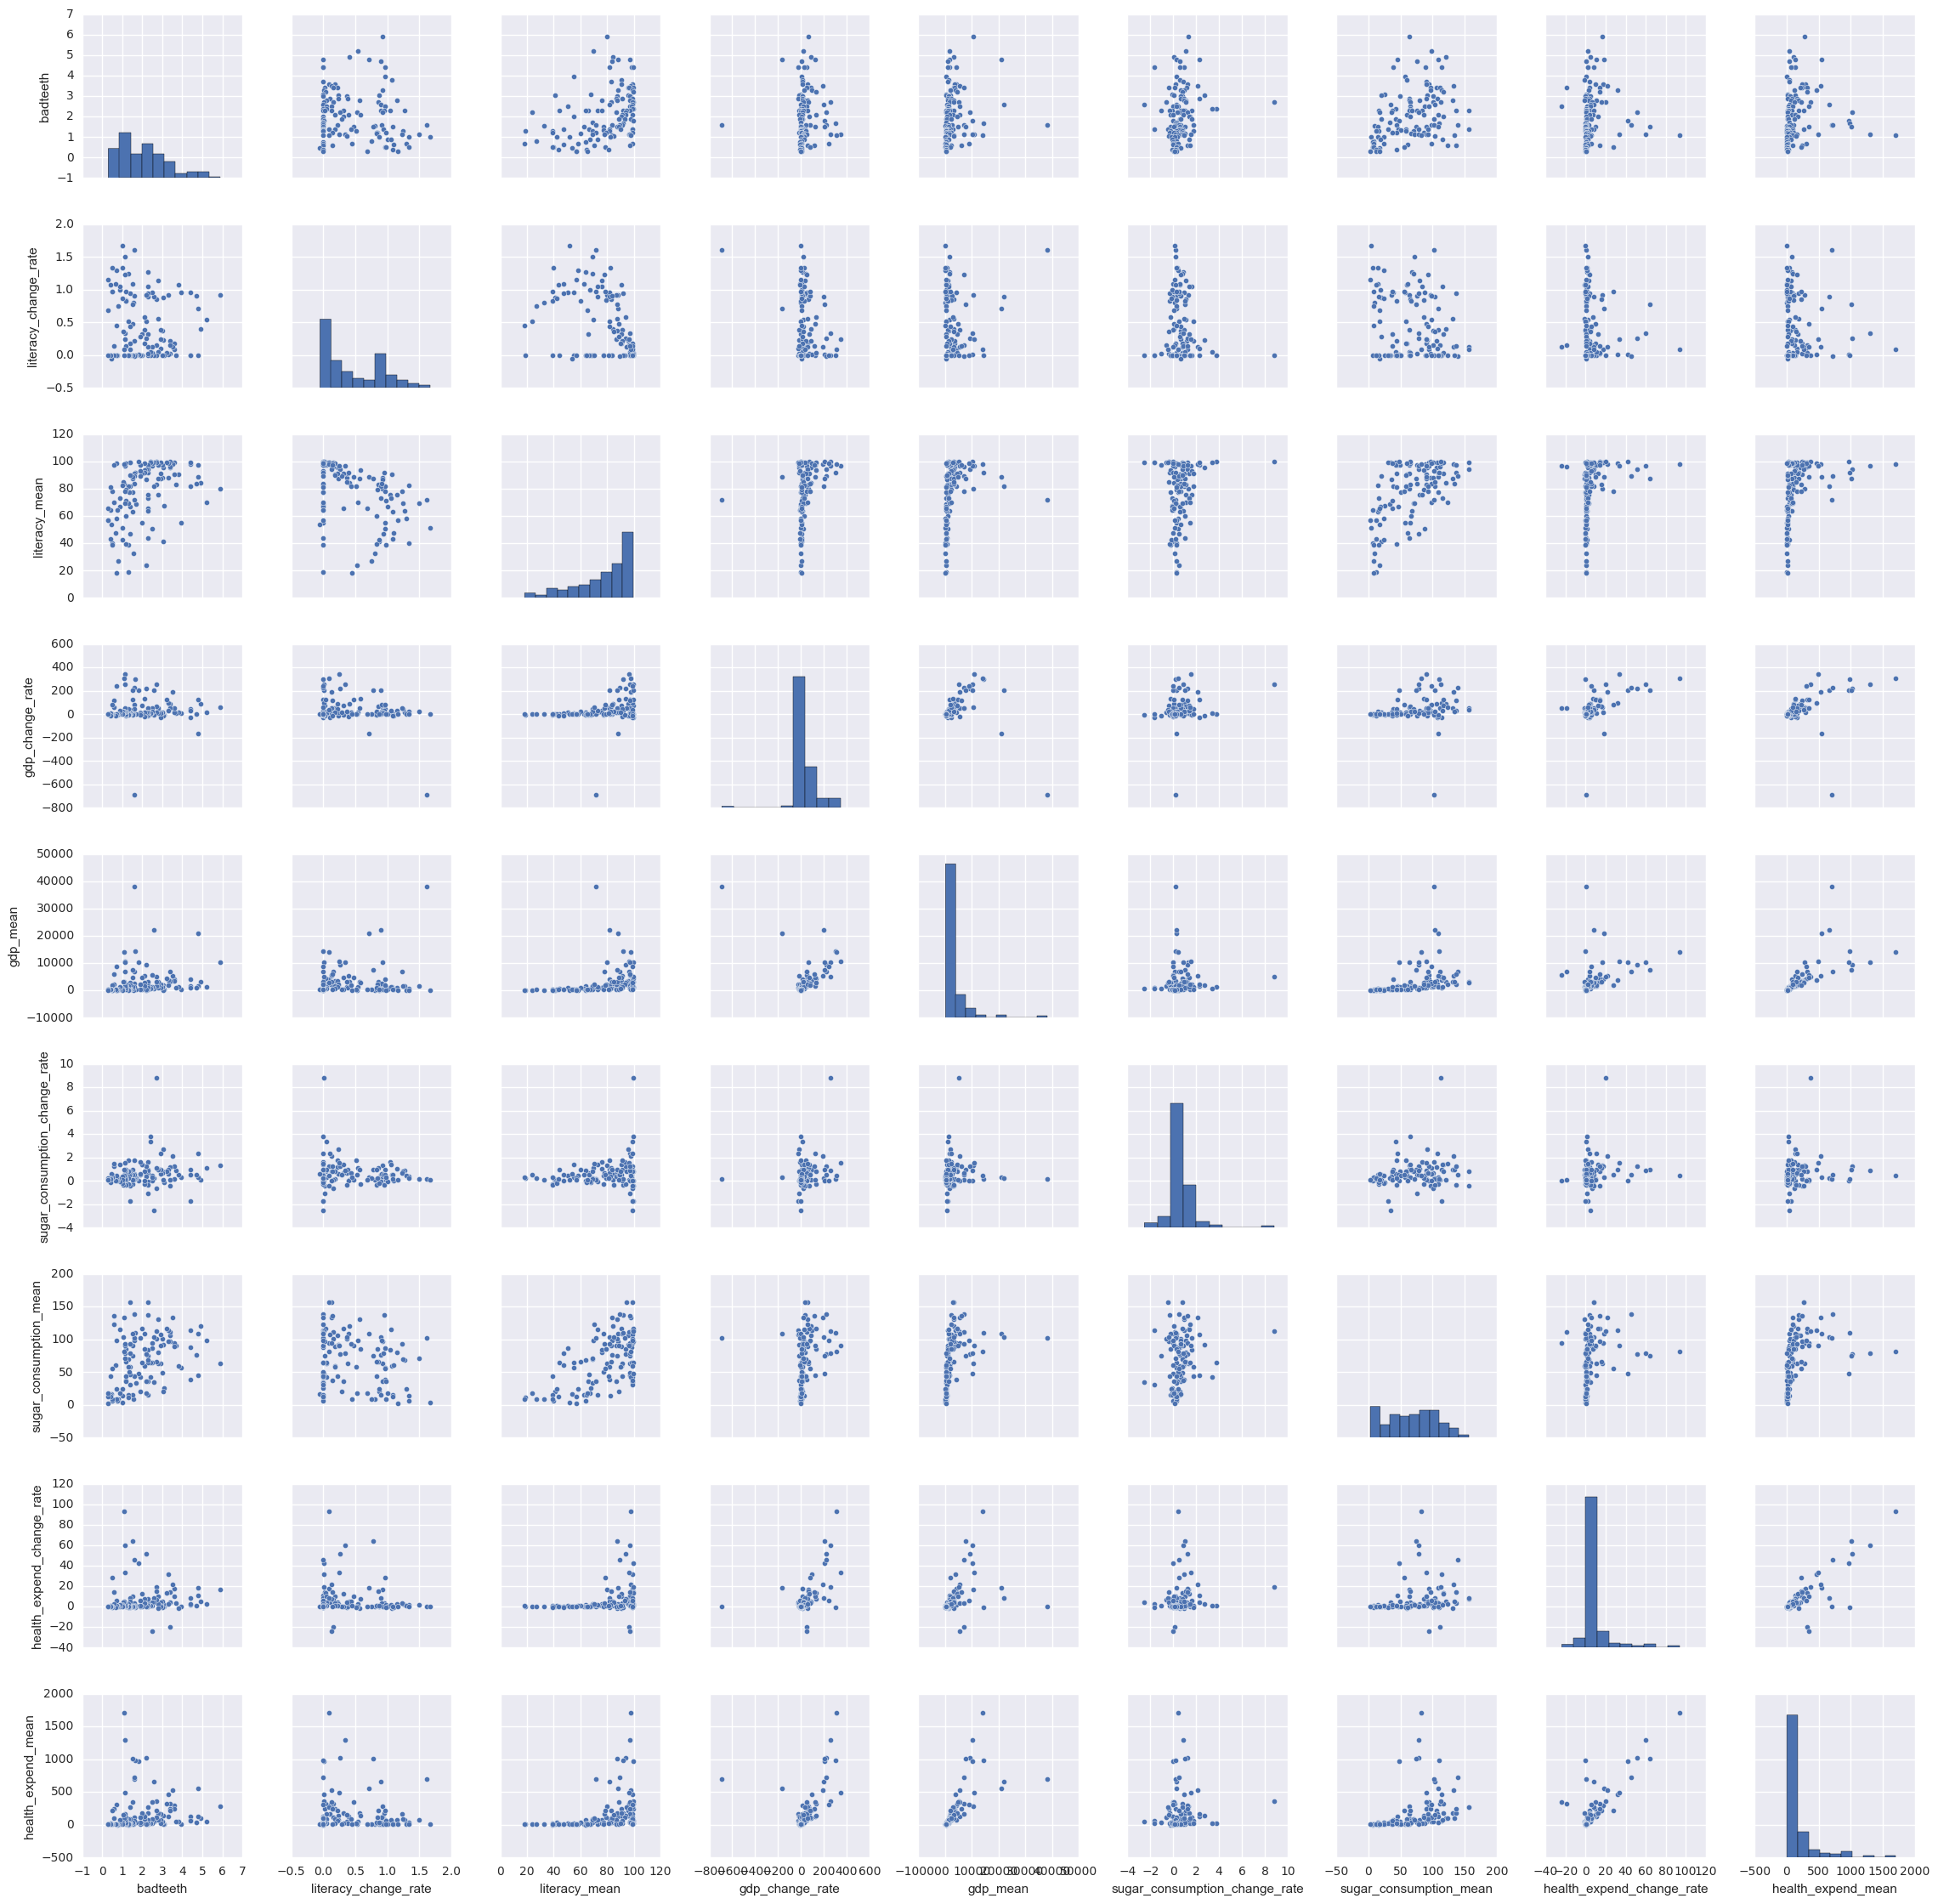

In [33]:
sns.pairplot(merged_data.dropna())

# Grupowanie
Sprawdźmy czy można wyszczególnić grupy między badteeth a atrybutem literacy i jaka byłaby ich ilość

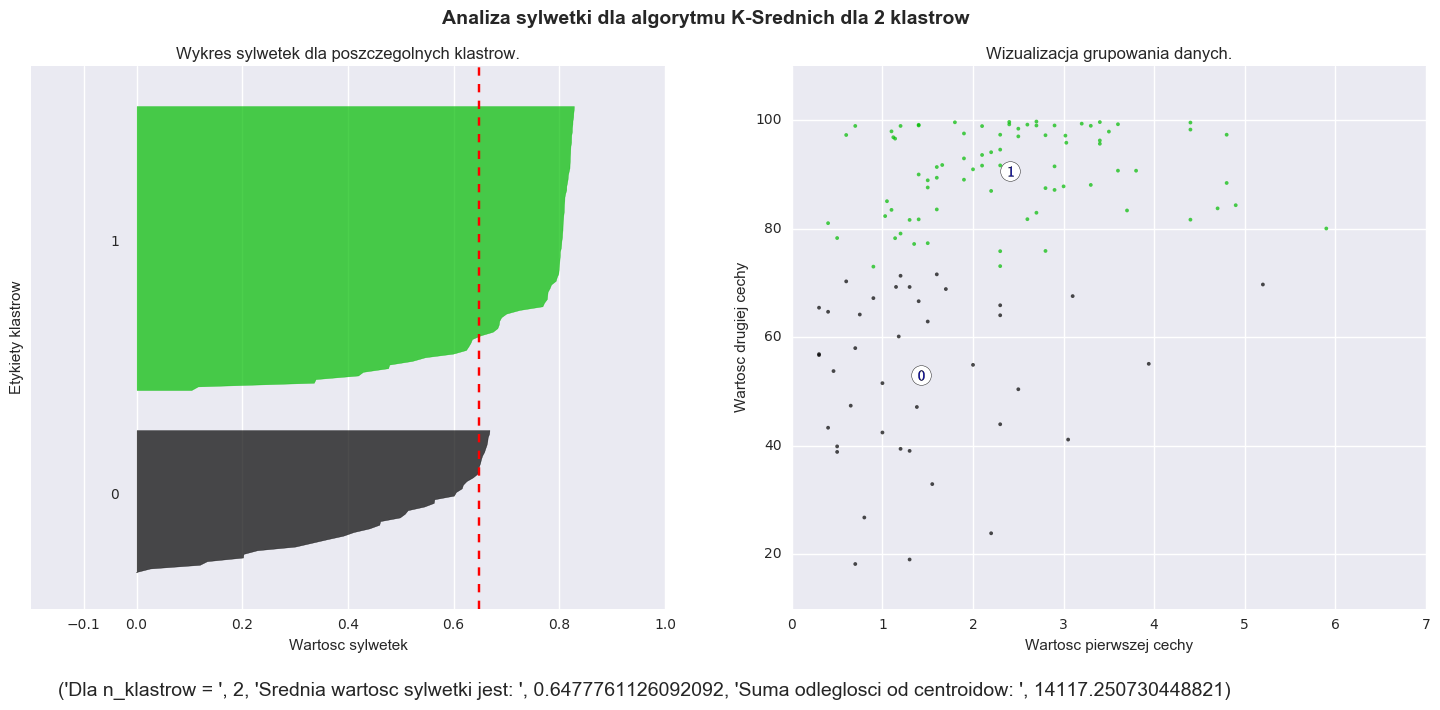

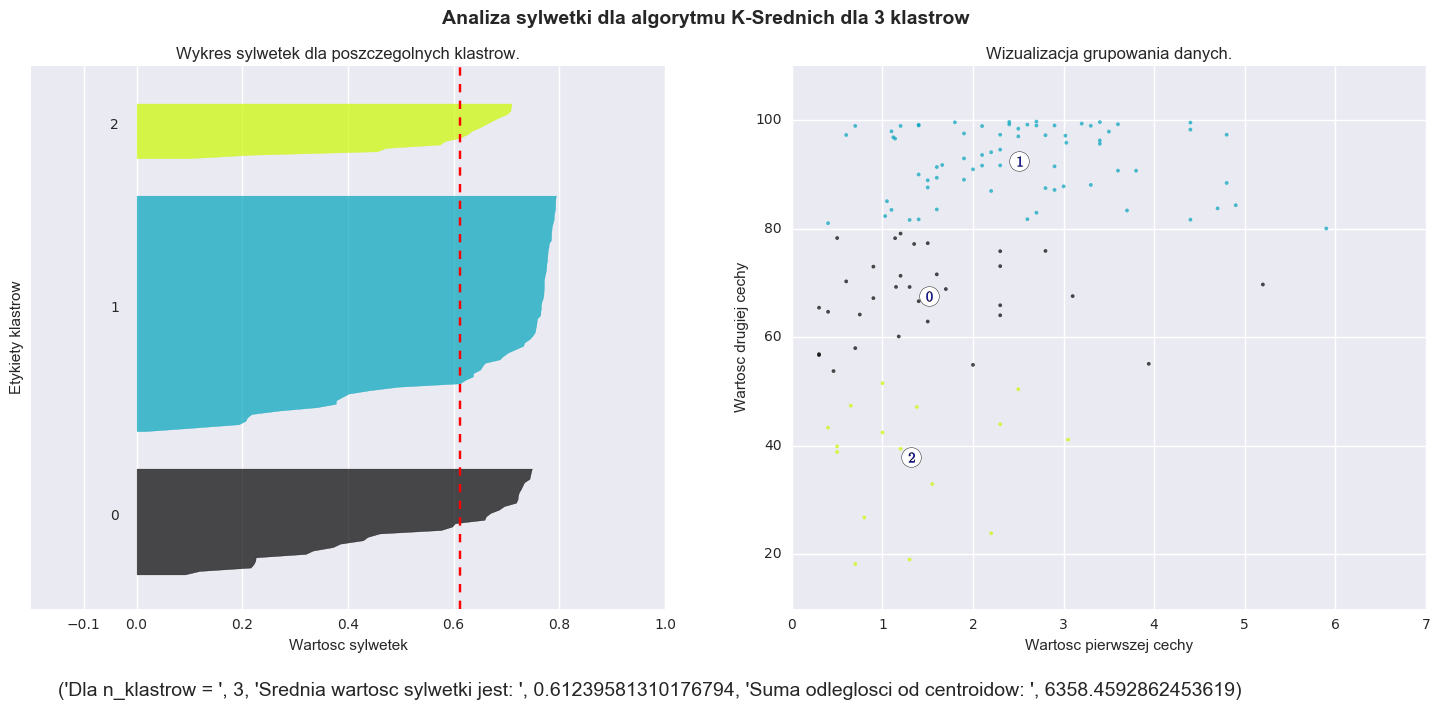

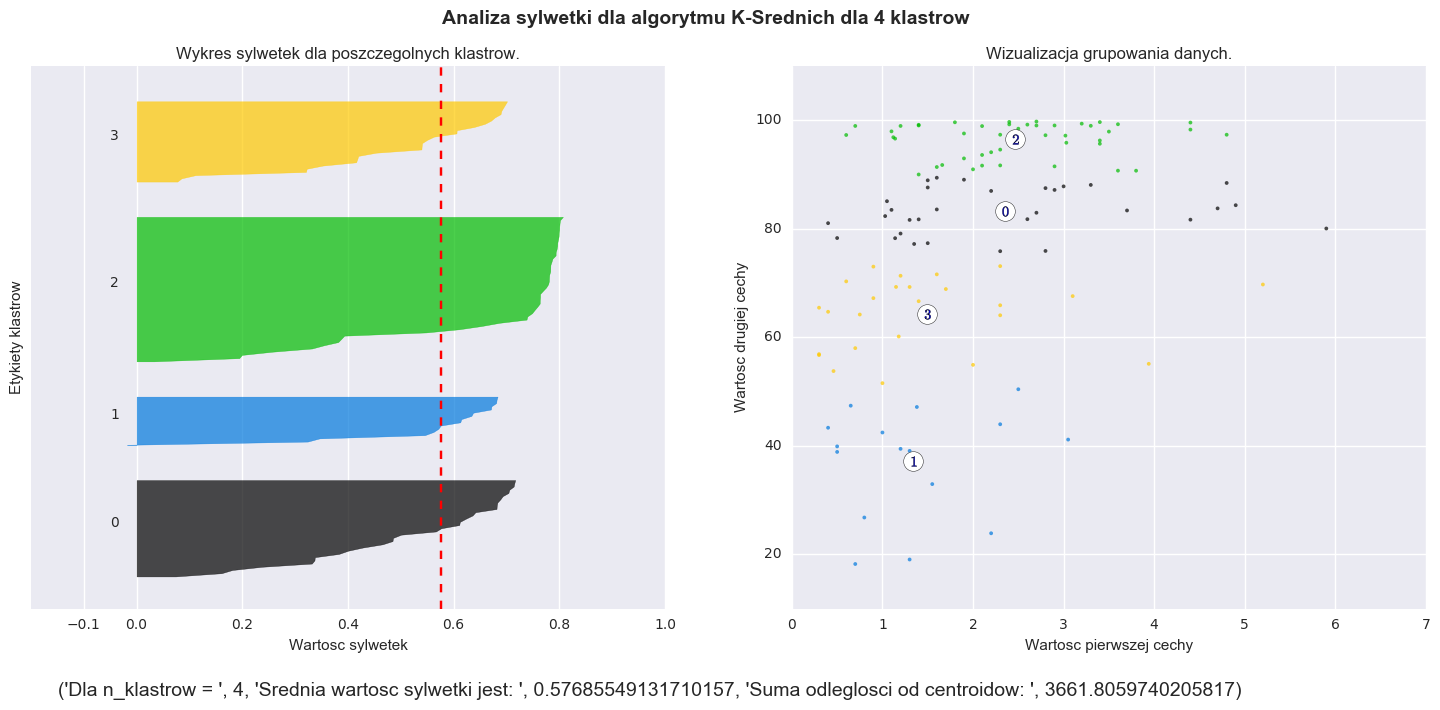

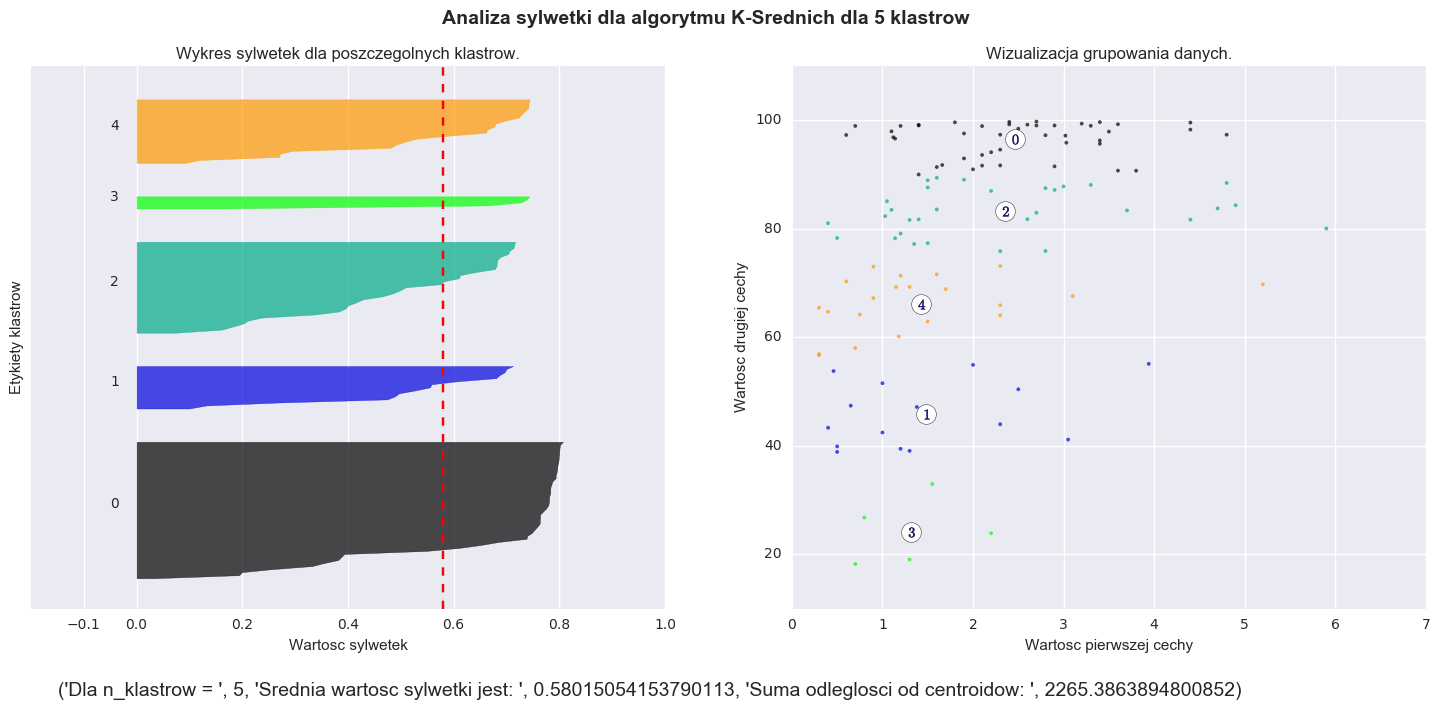

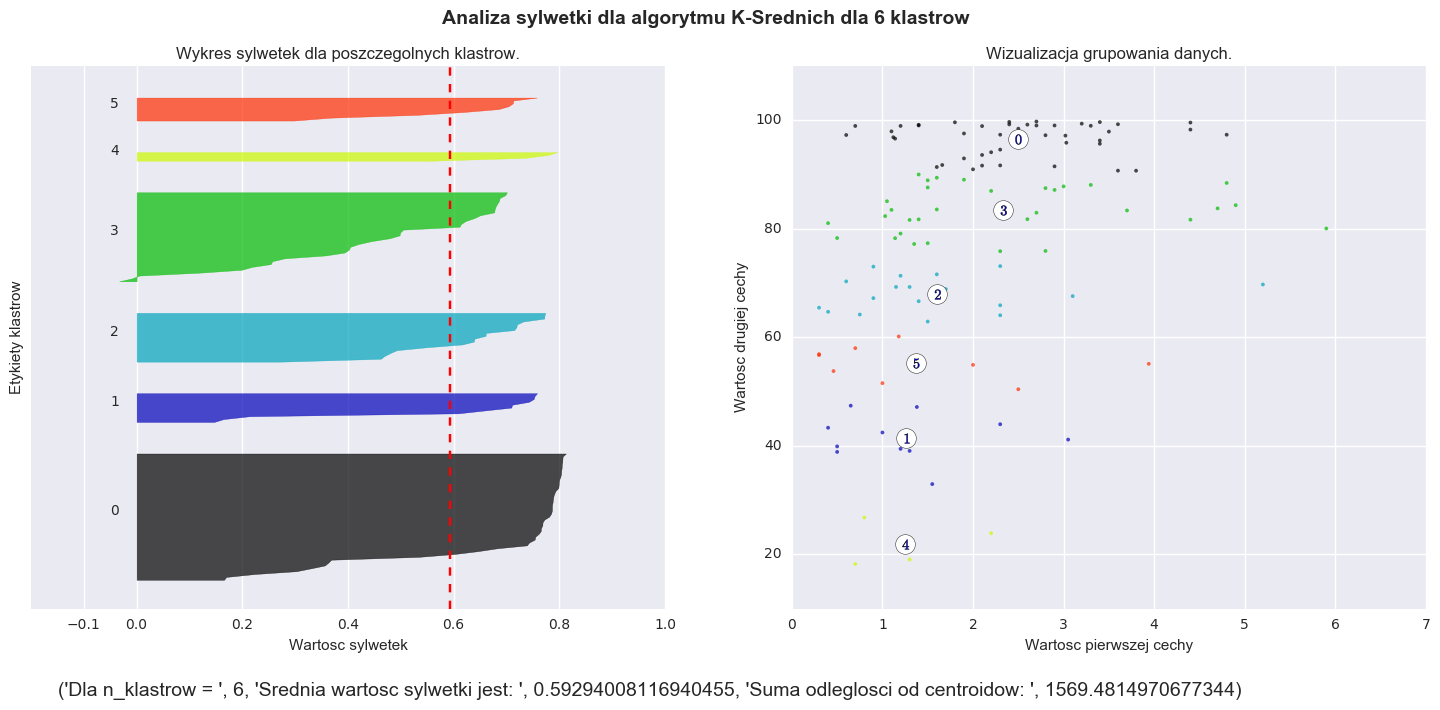

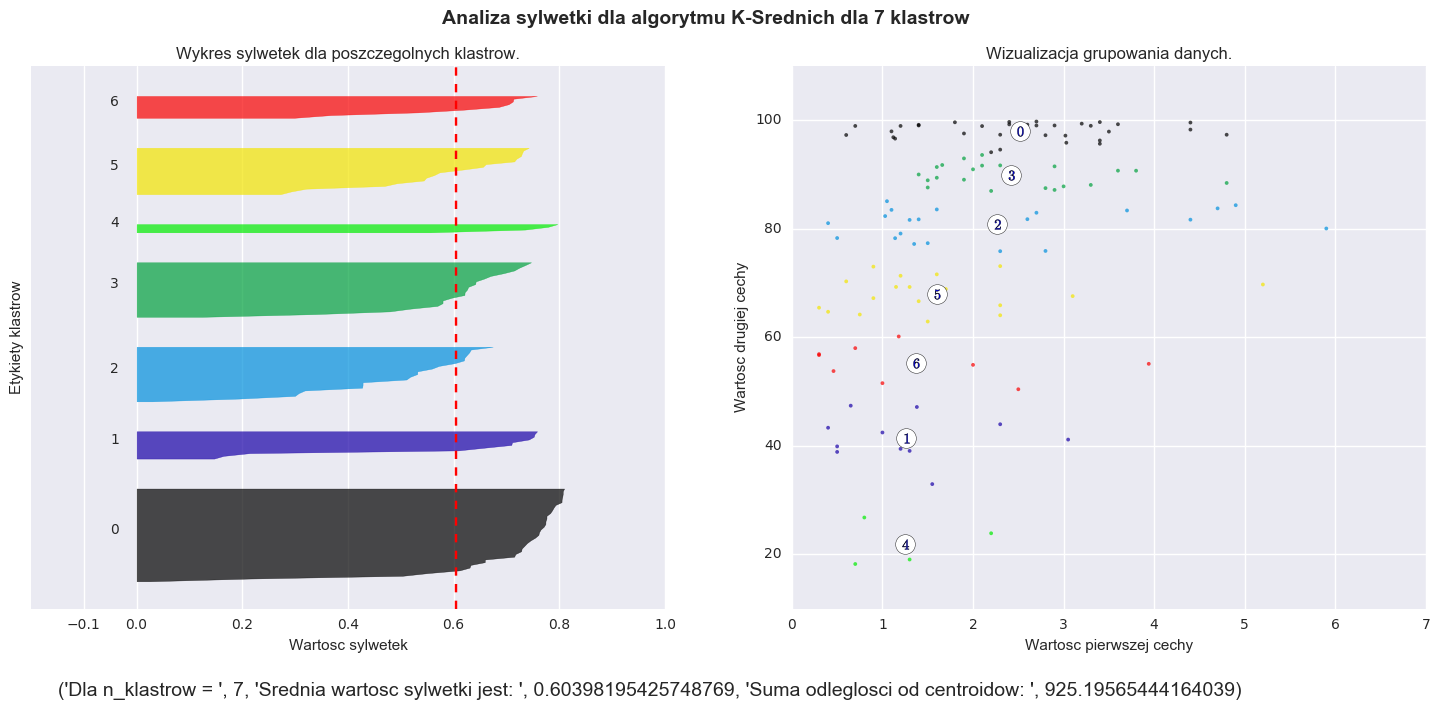

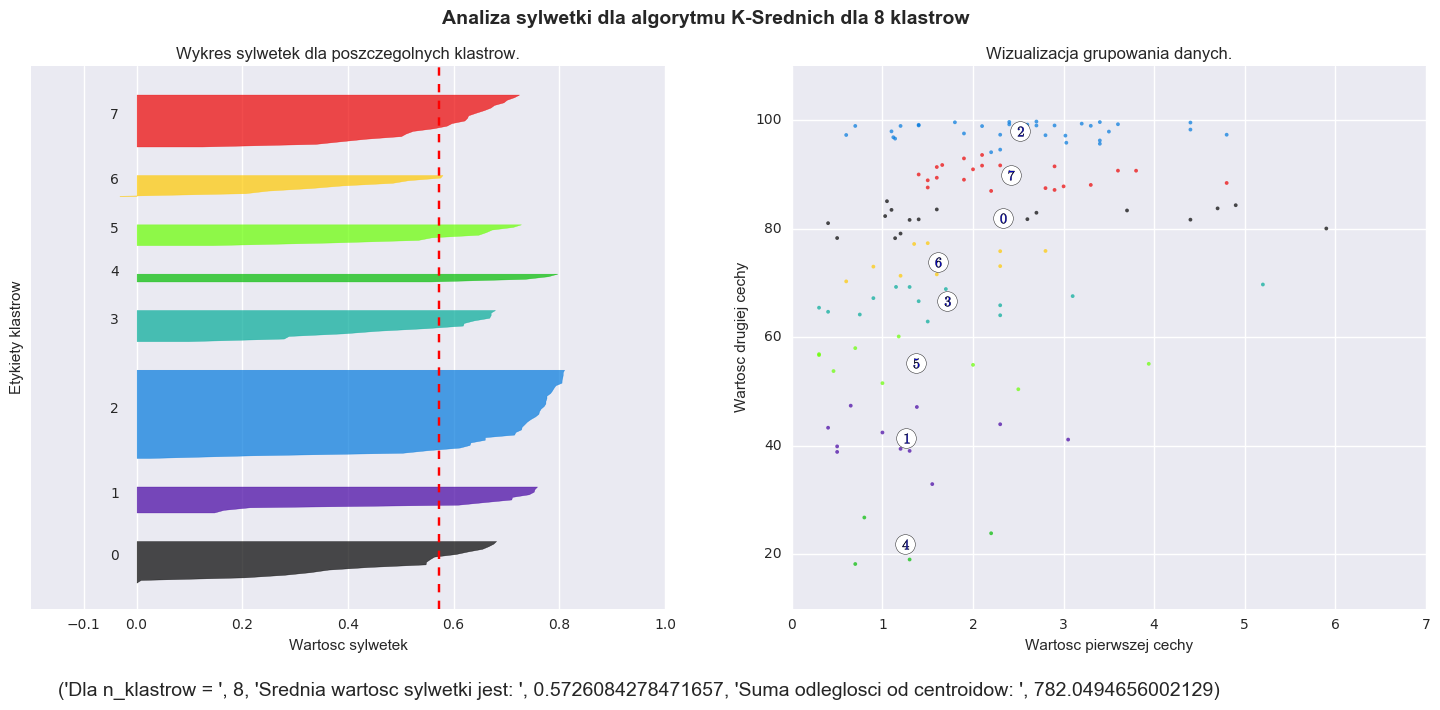

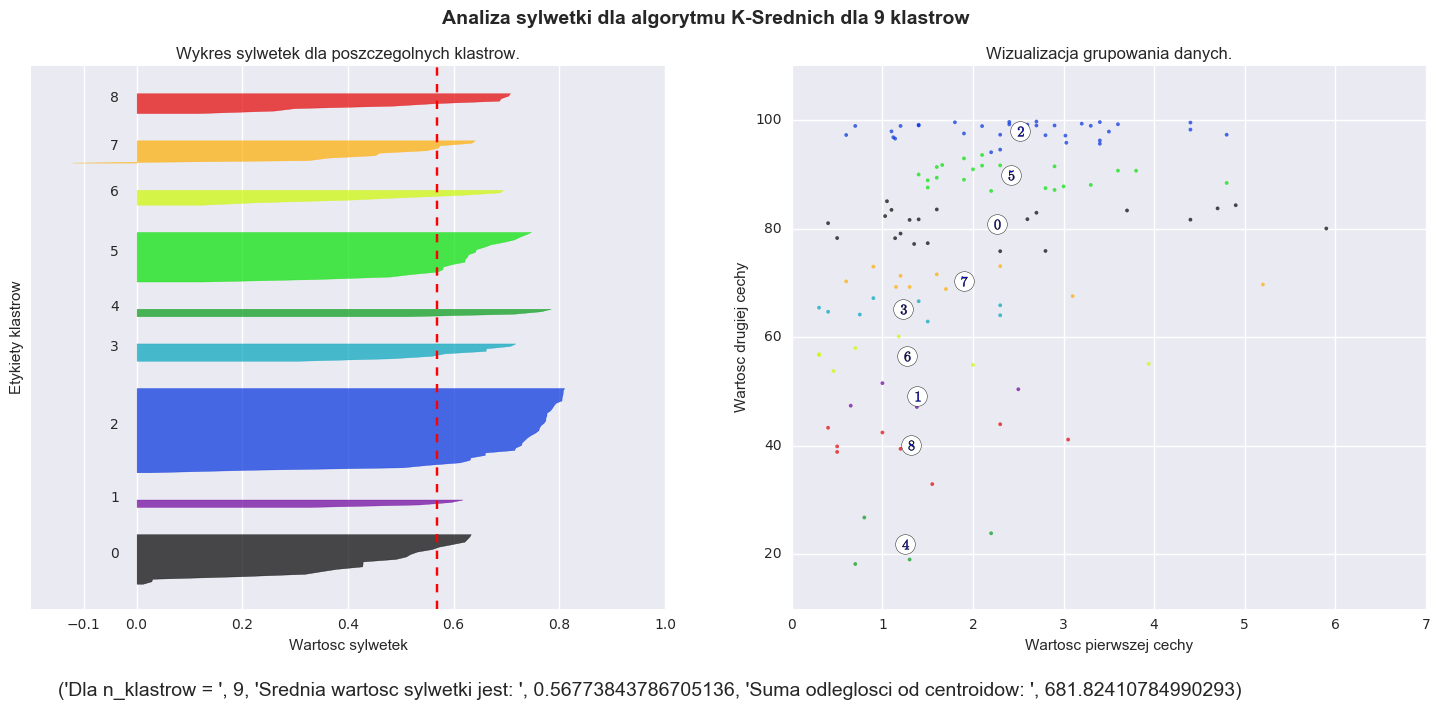

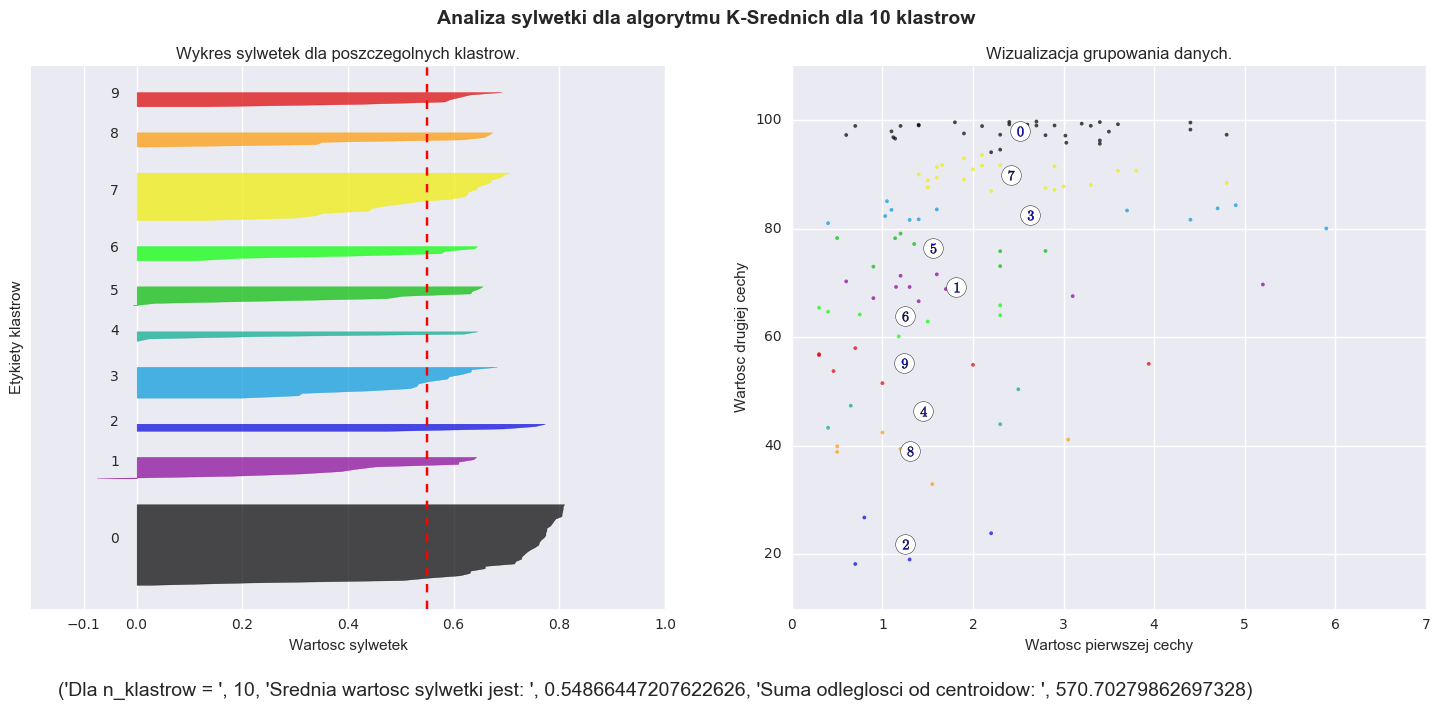

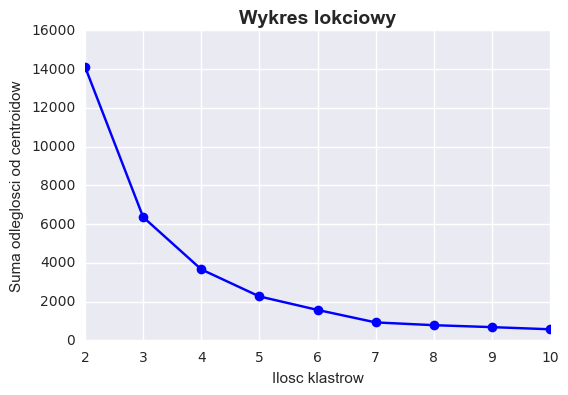

In [34]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

score = pd.Series()
dane1 = merged_data
for n_cluster in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dane1) + (n_cluster + 1) * 10])
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(merged_data[['badteeth','literacy_mean']])
    score = score.append(pd.Series(kmeans.inertia_))
    cluster_labels = kmeans.fit_predict(dane1[['badteeth','literacy_mean']])
    
    silhouette_avg = silhouette_score(dane1[['badteeth','literacy_mean']], cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dane1[['badteeth','literacy_mean']], cluster_labels)
    
    y_lower = 10
    for i in range(n_cluster):
        # Zebranie wyników sylwetek do próbek należących do klastra i ich sortowanie
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etykieta sylwetek z numerami klastrów w środku
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Wyliczenie przesunięcia w pionie dla kolejnego wykresu
        y_lower = y_upper + 10  # 10 dla kolejnej próbki
        
    ax1.set_title("Wykres sylwetek dla poszczegolnych klastrow.")
    ax1.set_xlabel("Wartosc sylwetek")
    ax1.set_ylabel("Etykiety klastrow")

    # Wyrysowanie wartości średniej sylwetki 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Wyczyszczenie etykiety osi Y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Drugi wykres będzie przedstawiał klastry
    colors = cm.spectral(cluster_labels.astype(float) / n_cluster)
    ax2.scatter(dane1.badteeth, dane1.literacy_mean, marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Etykietowanie klastrów
    centers = kmeans.cluster_centers_
    # Rysowanie białych kółek w cetroidach
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    # Numerowanie centroidów
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Wizualizacja grupowania danych.")
    ax2.set_xlabel("Wartosc pierwszej cechy")
    ax2.set_ylabel("Wartosc drugiej cechy")

    plt.suptitle(("Analiza sylwetki dla algorytmu K-Srednich "
                  "dla %d klastrow" % n_cluster),
                 fontsize=14, fontweight='bold')
    plt.figtext(0.14, 0, 
                ("Dla n_klastrow = ", n_cluster,
                 "Srednia wartosc sylwetki jest: ", silhouette_avg,  
                 "Suma odleglosci od centroidow: ", kmeans.inertia_), fontsize=14)
    plt.show()
    

plt.plot(range_n_clusters, score,'bo-')
plt.title("Wykres lokciowy", fontsize=14, fontweight='bold')
plt.xlabel("Ilosc klastrow")
plt.ylabel("Suma odleglosci od centroidow")

Jak widzimy na wykresie łokciowym najodpowiedniejszą ilością klastrów jest 4.

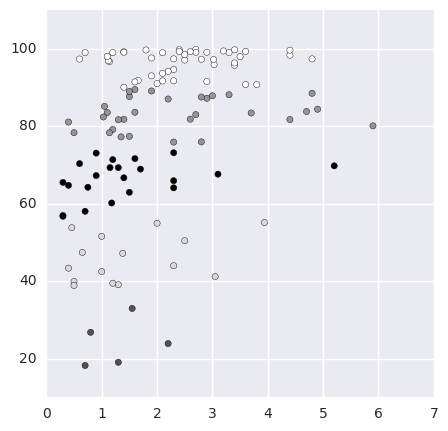

In [36]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(merged_data[['badteeth','literacy_mean']])
etykiety_klastrow = kmeans.fit_predict(merged_data[['badteeth','literacy_mean']])
plt.figure(figsize=(5,5))
# ['badteeth',' literacy_mean','gdp_mean','sugar_consumption_mean','health_expend_mean']
plt.scatter(merged_data.badteeth, merged_data.literacy_mean, marker='o', c=etykiety_klastrow)

In [37]:
print "Współrzędne centroidów:"
print(kmeans.cluster_centers_)

Współrzędne centroidów:
[[  2.46891304  96.47433061]
 [  1.47866667  45.89044653]
 [  2.35709677  83.21369884]
 [  1.31        24.16064902]
 [  1.42636364  66.2206401 ]]


# Korelacje
1. Sprawdzenie korelacje liniową i nieliniową między współczynnikami:

In [38]:
pearson = merged_data.corr(method='pearson',  min_periods=1)
pearson

,badteeth,literacy_change_rate,literacy_mean,gdp_change_rate,gdp_mean,sugar_consumption_change_rate,sugar_consumption_mean,health_expend_change_rate,health_expend_mean
badteeth,1.000000,-0.134244,0.386391,-0.000309,0.125417,0.147715,0.347595,0.004313,0.040692
literacy_change_rate,-0.134244,1.000000,-0.414511,-0.278760,0.080222,-0.111825,-0.229286,-0.144295,-0.139784
literacy_mean,0.386391,-0.414511,1.000000,0.296653,0.270767,0.186771,0.593800,0.304113,0.382020
gdp_change_rate,-0.000309,-0.278760,0.296653,1.000000,-0.068328,0.220693,0.219370,0.538066,0.473652
gdp_mean,0.125417,0.080222,0.270767,-0.068328,1.000000,0.037717,0.387159,0.386760,0.704226
sugar_consumption_change_rate,0.147715,-0.111825,0.186771,0.220693,0.037717,1.000000,0.191693,0.145786,0.087207
sugar_consumption_mean,0.347595,-0.229286,0.593800,0.219370,0.387159,0.191693,1.000000,0.224410,0.376812
health_expend_change_rate,0.004313,-0.144295,0.304113,0.538066,0.386760,0.145786,0.224410,1.000000,0.828255
health_expend_mean,0.040692,-0.139784,0.382020,0.473652,0.704226,0.087207,0.376812,0.828255,1.000000


In [39]:
spearman = merged_data.corr(method='spearman',  min_periods=1)
spearman

,badteeth,literacy_change_rate,literacy_mean,gdp_change_rate,gdp_mean,sugar_consumption_change_rate,sugar_consumption_mean,health_expend_change_rate,health_expend_mean
badteeth,1.000000,-0.122786,0.446451,0.173885,0.354165,0.234776,0.391015,0.257790,0.340707
literacy_change_rate,-0.122786,1.000000,-0.423507,0.011161,-0.077522,-0.039519,-0.159934,-0.118891,-0.123389
literacy_mean,0.446451,-0.423507,1.000000,0.406751,0.618772,0.187084,0.536577,0.540336,0.651859
gdp_change_rate,0.173885,0.011161,0.406751,1.000000,0.677532,0.279033,0.493834,0.587402,0.689973
gdp_mean,0.354165,-0.077522,0.618772,0.677532,1.000000,0.257202,0.782803,0.688299,0.950214
sugar_consumption_change_rate,0.234776,-0.039519,0.187084,0.279033,0.257202,1.000000,0.235210,0.271066,0.224784
sugar_consumption_mean,0.391015,-0.159934,0.536577,0.493834,0.782803,0.235210,1.000000,0.505474,0.753391
health_expend_change_rate,0.257790,-0.118891,0.540336,0.587402,0.688299,0.271066,0.505474,1.000000,0.753205
health_expend_mean,0.340707,-0.123389,0.651859,0.689973,0.950214,0.224784,0.753391,0.753205,1.000000


Jak widzimy w tabelach dodatnia korelacja spearmana(nieliniowa) na najsiliniejszym powiązaniu jest większa niż w korelacji pearsona. Liczba zepsutych zębów jest najbardziej skorelowana z współczynnikiem czytelnictwa w danym kraju, zaś ten z wydatkam na zdrowie i produktem krajowym brutto. Pierwsza z tych relacji przestaje dziwić gdy przyjrzymy się jak silnie skorelowane są te dwa współczynniki (gdp/wydatki na zdrowie)

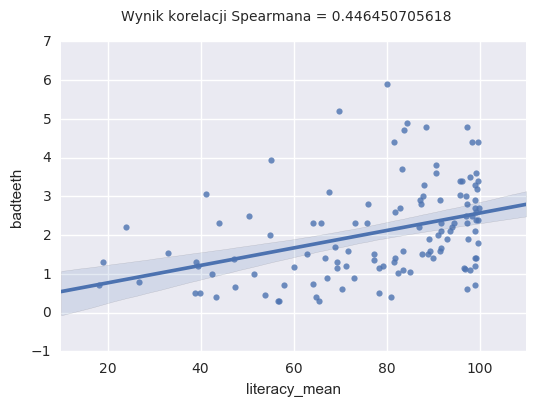

In [40]:
plt.figure().suptitle("Wynik korelacji Spearmana = " + str(spearman.badteeth["literacy_mean"]))

sns.regplot(x="literacy_mean", y="badteeth", data=merged_data);


Na podstawie tych danych przeprowadzimy regresję celem przewidzenia stanu uzębienia w zależności od parametrów.

# Regresje
Najpierw sprawdzimy samodzielną regresję od średniej czytelnictwa. Policzmy współczynniki:

In [59]:
import statsmodels.formula.api as smf

# dopasowany model liniowy
lm = smf.ols(formula='badteeth ~ literacy_mean', data=merged_data).fit()

# współczynniki
lm.params

Intercept        0.317363
literacy_mean    0.022511
dtype: float64

Interpretacja współczynników:
   Wzrost "jednostkowy" w średniej czytelnictwa jest powiązany ze wzrotem 0.022624 "jednostkowym" w dziurach:
Sprawdźmy więc pewność wyników:

In [60]:
# przedziały ufności dla danych współczynników
lm.conf_int()

,0,1
Intercept,-0.477081,1.111808
literacy_mean,0.012673,0.032350


Sprawdźmy dopasowanie naszego liniowego modelu poprzez wartosć R-squared. Jest to proporcja zmiennych w obserwowanym zbiorze które są wyjaśnione przez model.
Wartość ta zawiera się między 0 a 1, a im wyższa tym lepsza. Jak widzimy w naszym przypadku jest bardzo niska.

In [61]:
lm.rsquared


0.14929762993248696

Sprawdźmy więc inny model dla naszej regresji. Użyjmy więcej niż jednego czynnika:

In [62]:
# stwórz model ze wszystkimi atrybutami poza change_rates
lm = smf.ols(formula='badteeth ~ literacy_mean+gdp_mean+sugar_consumption_mean+health_expend_mean', data=merged_data).fit()

# współczynniki
lm.params

Intercept                 0.237509
literacy_mean             0.019377
gdp_mean                  0.000035
sugar_consumption_mean    0.005987
health_expend_mean       -0.001127
dtype: float64

In [63]:
lm.conf_int()

,0,1
Intercept,-0.568752,1.043770
literacy_mean,0.007023,0.031731
gdp_mean,-0.000023,0.000093
sugar_consumption_mean,-0.000712,0.012686
health_expend_mean,-0.002179,-0.000076


Jedynym czynnikiem mającym wpływ na spadek zepsutych zębów są wydatki na zdrowie w kraju (ujemne wartości).

In [64]:
# podsumowanie modelu
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               badteeth   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     7.254
Date:                Sat, 21 Jan 2017   Prob (F-statistic):           3.06e-05
Time:                        23:14:26   Log-Likelihood:                -178.44
No. Observations:                 119   AIC:                             366.9
Df Residuals:                     114   BIC:                             380.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  0.2375      0.407      0.584      0.561        -0.569     1.044
literacy_mean              0.0194      0.006      3.107      0.002         0.007     0.032
gdp_mean                3.499e-05   2.92e-05      1.196      0.234     -2.29e-05  9.29e-05
sugar_consumption_mean     0.0060      0.003      1.770      0.079        -0.001     0.013
health_expend_mean        -0.0011      0.001     -2.123      0.036        -0.002 -7.55e-05
==============================================================================
Omnibus:                       13.374   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.297
Skew:                           0.776   Prob(JB):                     0.000786
Kurtosis:                       3.687   Cond. No.                     2.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Z tych informaci widać m.in. iż ten model ma wyższy wspólczynnik R-square. Jest dokładniejszy niż poprzedni, nadal jest to jednak niewielka wartość.  

In [65]:
# stwórz model z ważnymi atrybutami 
lm = smf.ols(formula='badteeth ~ literacy_mean+gdp_change_rate+sugar_consumption_change_rate+sugar_consumption_mean', data=merged_data).fit()
# współczynniki
lm.params

Intercept                        0.299232
literacy_mean                    0.017871
gdp_change_rate                 -0.001770
sugar_consumption_change_rate    0.095335
sugar_consumption_mean           0.005647
dtype: float64

In [66]:
lm.conf_int()

,0,1
Intercept,-0.506782,1.105246
literacy_mean,0.005517,0.030225
gdp_change_rate,-0.003851,0.000311
sugar_consumption_change_rate,-0.090104,0.280773
sugar_consumption_mean,-0.000831,0.012125


In [67]:
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               badteeth   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     6.894
Date:                Sat, 21 Jan 2017   Prob (F-statistic):           5.25e-05
Time:                        23:14:27   Log-Likelihood:                -179.04
No. Observations:                 119   AIC:                             368.1
Df Residuals:                     114   BIC:                             382.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                         0.2992      0.407      0.735      0.464        -0.507     1.105
literacy_mean                     0.0179      0.006      2.866      0.005         0.006     0.030
gdp_change_rate                  -0.0018      0.001     -1.685      0.095        -0.004     0.000
sugar_consumption_change_rate     0.0953      0.094      1.018      0.311        -0.090     0.281
sugar_consumption_mean            0.0056      0.003      1.727      0.087        -0.001     0.012
==============================================================================
Omnibus:                       16.992   Durbin-Watson:                   0.344
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.427
Skew:                           0.900   Prob(JB):                     6.05e-05
Kurtosis:                       3.824   Cond. No.                         523.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Wnioski

Podsumowując nasze dane możemy stwierdzić iż liczba zepsutych zębów jest dodatnio skorelowana z średnimi czynnikami :
    poziomu piśmiennictwa, zamożności kraju, spożycia cukru. W największym stopniu z tym pierwszym.
    Może to świadczyć iż wraz z rosnącą świadomością społeczeństwa częściej sięga ono po pomoc lekarską, która zostaje odnotowywana.
    
Jedynym uśrednionym atrybutem ujemnie skorelowanym z liczbą zepsutych zębów są wydatki państwa na resort zdrowia. Naszym zdaniem pomaga to na wczesne zapobieganie dalszemu rozwojowi próchnicy już na wczesnych etapach co blokuje jej dalsze rozprzestrzenianie.
Ponadto przy wyliczanie prędkości zmian zachodzących zauważyliśmy, iż próchnica skorelowana jest ujemnie w krajach szybko rozwijających poziom czytelnictwa. Jest to dość intuicyjne